In [ ]:
# !pip install -q langchain openai tiktoken langchain_community python-pptx chromadb faiss-cpu tabula-py

## Importing Modules

In [1]:
import re
import os
import uuid
import base64
import spacy
import glob
import pandas as pd

from bs4 import BeautifulSoup
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS, Chroma
# from langchain_community.vectorstores import Chroma, FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings


/home/preeti/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("API_KEY")
db_url = os.getenv("DB_URL")
print(api_key)
print(db_url)



your_api_key_here
your_database_url_here


In [3]:
# your pdf path
file_path = 'dataset/attention_all_you_need.pdf'

In [27]:
# extracting Text, Images and Tables from PDF file

output_path = "./images"

raw_pdf_elements = partition_pdf(
                      filename = file_path,
                      extract_images_in_pdf=True,
                      infer_table_structure=True,
                      chunking_strategy="by_title",
                      max_characters=4000,
                      new_after_n_chars=3800,
                      combine_text_under_n_chars=2000,
                      extract_image_block_output_dir= "./images",
                  )


In [5]:
# Get text summaries and table summaries

text_elements = []
table_elements = []
table_elements1 = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm = Ollama(model="llama3"),
    prompt=PromptTemplate.from_template(summary_prompt)
)


for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        table_elements1.append(e.metadata.text_as_html)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

/home/preeti/miniconda3/envs/llm/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/home/preeti/miniconda3/envs/llm/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [6]:
#Extracting tables and saving into folder

def get_tables(table_elements1):
    for i in range(len(table_elements1)):
        table = table_elements1[i]

        # for getting the header from
        data = []
        list_header = []
        soup = BeautifulSoup(table,'html.parser')
        header = soup.find_all("table")[0].find("tr")

        for items in header:
            try:
                list_header.append(items.get_text())
            except:
                continue

        # for getting the data
        HTML_data = soup.find_all("table")[0].find_all("tr")[1:]

        for element in HTML_data:
            sub_data = []
            for sub_element in element:
                try:
                    sub_data.append(sub_element.get_text())
                except:
                    continue
            data.append(sub_data)

        # Storing the data into dataframe
        try:
            dataFrame = pd.DataFrame(data = data,  columns = list_header)
        except:
            dataFrame = pd.DataFrame(data = data)

        os.makedirs('tables', exist_ok=True)
        # Converting Pandas DataFrame
        dataFrame.to_csv(f'tables/table_{i}.csv')

get_tables(table_elements1)

In [7]:
# loading Sapcy model for text cleaning and extracting only relvant information

nlp = spacy.load('en_core_web_sm')

def top_sentences(page_text):
    summarized_pages=[]
    for i in page_text:
        # print(i)
        try:
            textt=""
            pattern = r'\[\d+]+'
            text = re.sub(pattern, '', i)
            text=text.replace("\n"," ")
            # parse the text using Spacy
            doc = nlp(text)

            # create a list of (sentence, score) tuples based on sentence similarity
            sentences = [(sent.text.strip(), sent.similarity(doc))
                        for sent in doc.sents]
            # print('sen ',sentences)
            # sort the list in descending order of similarity score and select top 5 sentences
            top_sentences = sorted(sentences, key=lambda x: x[1], reverse=True)[:3]

            # print the top 5 sentences
            for i, (sentence, score) in enumerate(top_sentences):
                textt += "".join(sentence)
            # print(f'Top {i+1} sentence: {sentence}\nSimilarity score: {score:.2f}\n')
            summarized_pages.append([textt])
        except:
            pass
            print("error top_sent")
    return summarized_pages

text_summaries1 = top_sentences(text_summaries)
text_summaries1 = [j for sub in text_summaries1 for j in sub]

text_elements1 = top_sentences(text_elements)
text_elements1 = [j for sub in text_elements1 for j in sub]

table_elements1 = top_sentences(table_elements)
table_elements1 = [j for sub in table_elements1 for j in sub]

table_summaries1 = top_sentences(table_summaries)
table_summaries1 = [j for sub in table_summaries1 for j in sub]


/tmp/ipykernel_7816/1029572453.py:18: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  sentences = [(sent.text.strip(), sent.similarity(doc))


# Converting Image to text
For understanding the context of image

In [8]:
from transformers import pipeline

# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')


def summarize_image(img_path):
    captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
    img_txt = captioner(img_path)
    return img_txt[0]['generated_text']


for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(image_path)
        image_summaries.append(summary)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/home/preeti/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [9]:
# image_elements
image_summaries

['a diagram of a multi - layered multi - layered multi - layered multi - layer',
 'a diagram of the algorithm']

## Storing all informaton into FAISS vector database

In [10]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements1, text_summaries1):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements1, table_summaries1):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding = OllamaEmbeddings(model="llama3"))

In [11]:
# vectorstore.save_local("faiss_index")
# embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
# db = FAISS.load_local("faiss_index", embeddings)

### Defining Prompt for PPT

In [12]:

# prompt_template = """
#       You are a PPT creator AI expert your role is to generate atleast 8 detailed ppt slides contaning topic and five points based on the following context,
#       which can include text, images and tables.
#       slide formate should be slide: title: points:
#       {context}
#       Question: {question}
#       Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
#       Just return the helpful answer in as much as detailed possible.
#       Answer:
#     """

prompt_template = """
      You are a PPT creator AI expert your role is to generate atleast 8 detailed ppt slides contaning topic and five points based on the following context,
      slide formate should be slide: title: points:
      {context}
      Question: {question}
      Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
      Just return the helpful answer in as much as detailed possible.
      Answer:
    """


### Creating RAG Chain

In [13]:
qa_chain = LLMChain(llm = Ollama(model="llama3"),
                        prompt = PromptTemplate.from_template(prompt_template))


def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images, relevant_docs

In [14]:
# result, relevant_images, context = answer("Modeling Tabular Data using Conditional GAN")
# print(result)
result, relevant_images, context = answer("attention all ypu need")
print(result)

Here are eight detailed PPT slides on the topic of Self-Attention Layers:

**Slide 1: Introduction to Self-Attention Layers**

* Title: "Self-Attention Layers: A New Era in Neural Networks"
* Points:
	+ Definition of self-attention layers
	+ Why traditional recurrent and convolutional layers are insufficient
	+ Overview of the benefits of self-attention layers

[Image: a simple diagram illustrating the concept of self-attention]

**Slide 2: How Self-Attention Layers Work**

* Title: "The Mechanics of Self-Attention"
* Points:
	+ Attention mechanism: calculating weights for each element in the input sequence
	+ Query, Key, and Value matrices
	+ Computing the output as a weighted sum of the values

[Image: a diagram illustrating the attention mechanism]

**Slide 3: Advantages of Self-Attention Layers**

* Title: "Why Self-Attention is Better"
* Points:
	+ Parallelization: no sequential computation required
	+ Flexibility: can be applied to varying input sequences and lengths
	+ Improved 

In [15]:
# result, relevant_images, context = answer("a plot of the number of carbons in the carbon cycle")
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHVA2oDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2K58V2EOoXtjbxXN9c2CLJeJaxhvIDAkbskZJAJ2jJ9qx/GFzo/in4S6xqduIL6zfTJ7i2kZM7WWNsMMjKsCPqCKraTqdtrPibxVHokVvpsdnMIdSvlQGe5mVSOAflULgjcwbPPA61zHgs5/Zgvuemm6h/OWgDtPA1/a6Z8

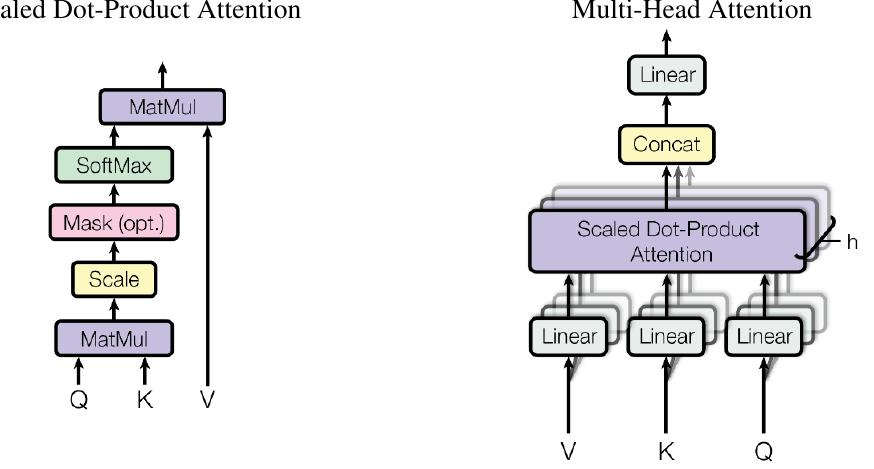

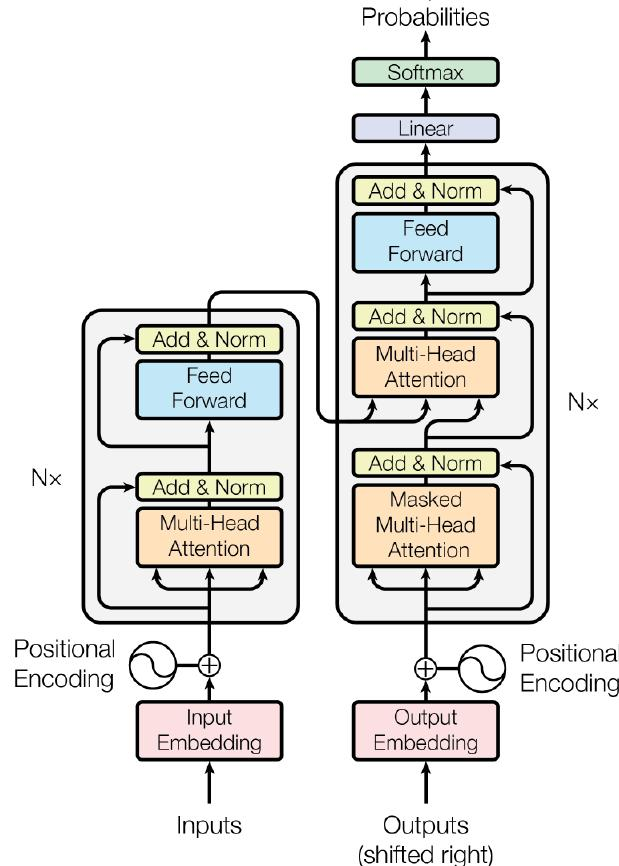

In [16]:
if len(relevant_images)>0:
  for img in relevant_images:
    display.display(display.Image(base64.b64decode(img)))

### Post preprocessing on generated text

In [17]:
def extract_slides(text):
    slides = []
    slide_pattern = re.compile(r'Slide (\d+):\nTitle: (.+?)\nPoints:(.+?)(?=Slide \d+:|\Z)', re.DOTALL)
    point_pattern = re.compile(r'\* (.+?)\n')  # Pattern to extract each point

    matches = slide_pattern.findall(text)

    final_list = []

    for match in matches:
        slide_number = match[0]
        title = match[1].strip()
        points_match = point_pattern.findall(match[2])
        points = [point.strip() for point in points_match]
        
        slide_dict = {
            "Topic": title,
            "Summary": points
        }
        
        final_list.append(slide_dict)

    return final_list

# slides = extract_slides(result)


In [20]:
import re


def extract_slides(text):
    slide_pattern = r'\*\*Slide (\d+): (.+?)\*\*[\s\S]*?Points:(.+?)(?=\n\n\[|\Z)'
    slides = re.findall(slide_pattern, text, re.DOTALL)

    final_list = []
    for slide in slides:
        slide_number = slide[0].strip()
        title = slide[1].strip()
        
        slide_dict = {
            "Topic": title,
            "Summary": slide[2]
        }

        final_list.append(slide_dict)

    return final_list


# slides = extract_slides(text1)
slides = extract_slides(result)


slides

[{'Topic': 'Introduction to Self-Attention Layers',
  'Summary': '\n\t+ Definition of self-attention layers\n\t+ Why traditional recurrent and convolutional layers are insufficient\n\t+ Overview of the benefits of self-attention layers'},
 {'Topic': 'How Self-Attention Layers Work',
  'Summary': '\n\t+ Attention mechanism: calculating weights for each element in the input sequence\n\t+ Query, Key, and Value matrices\n\t+ Computing the output as a weighted sum of the values'},
 {'Topic': 'Advantages of Self-Attention Layers',
  'Summary': '\n\t+ Parallelization: no sequential computation required\n\t+ Flexibility: can be applied to varying input sequences and lengths\n\t+ Improved performance: better handling of long-range dependencies'},
 {'Topic': 'Comparison with Recurrent Layers',
  'Summary': '\n\t+ Recurrent layers are sequential, while self-attention is parallel\n\t+ Self-attention is faster for shorter input sequences\n\t+ Recurrent layers are better suited for modeling temporal

In [21]:
# function for fetching images

def get_images():
    try:
        filenames = [f for f in os.listdir('./images/') if os.path.isfile(os.path.join('./images/', f))]
        return filenames
    except Exception as e:
        print(e)

def get_table():
    try:
        filenames = [f for f in os.listdir('./tables/') if os.path.isfile(os.path.join('./tables/', f))]
        return filenames
    except Exception as e:
        print(e)


# function to empty the images folder
def empty_images():
    folder_path = "./images/"
    file_list = glob.glob(os.path.join(folder_path, "*"))
    for file_path in file_list:
        try:
            os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")


### Generating PPT

In [28]:
from pptx import Presentation
from pptx.util import Inches,Pt
from pptx.enum.text import MSO_ANCHOR, MSO_AUTO_SIZE

def presentate(defined_list):
    prs = Presentation()

    def add_slide(prs, layout, title, subtitle):
        slide = prs.slides.add_slide(layout)
        slide.shapes.title.text = title
        slide.placeholders[1].text=subtitle
        font = slide.shapes.title.text_frame.paragraphs[0].font
        font.name = 'Arial'
        font.size = Pt(30)
        font.bold = True
        font.italic = False
        for x in  slide.placeholders[1].text_frame.paragraphs:
            font1= x.font
            font1.name = 'Arial'
            font1.size = Pt(20)
            font1.bold = False
            font1.italic = False
        print(f'slide added {title}')
        return slide
    


    def add_slide_img(prs, layout, img_path):
        slide = prs.slides.add_slide(layout)
        img_path =  ""+img_path
        left =  Inches(1.10)
        top = Inches(0.7)
        width = Inches(8)
        height = Inches(6)
        pic = slide.shapes.add_picture(img_path, left, top, width, height)
        print(f'image added {img_path}')


    def add_slide_table(prs, layout, path):
        df = pd.read_csv(path)
        # Add a new slide
        slide = prs.slides.add_slide(layout)

        left =  Inches(0)
        top = Inches(0)
        width = Inches(10)
        height = Inches(1)
        # Create a table in the slide
        slide = slide.shapes.add_table(df.shape[0], df.shape[1], left, top, width, height)

        table = slide.table
        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                cell = table.cell(i, j)
                cell.text = str(df.iloc[i][j])
        print(f'table added {path}')


    title_slide_layout = prs.slide_layouts[1]
    title_slide_layimg = prs.slide_layouts[6]


    for i in range (0,len(defined_list)):
        slide = add_slide(prs, title_slide_layout, defined_list[i]["Topic"], defined_list[i]["Summary"])
        try:
            slide2 = add_slide_img(prs, title_slide_layimg, "images/"+get_images()[i])
        except:
            # print('no image find')
            # slide2 = add_slide_img(prs,title_slide_layimg,"images/"+get_images()[1])
            # empty_images()
            print('No image found')

        try:
            # table_list = ['/tables/table_3.csv', '/tables/table_4.csv', '/tables/table_5.csv']
            table_list = get_table()
            # print(table_list[i])
            slide3 = add_slide_table(prs, title_slide_layimg, "tables/"+get_table()[i])
        except:
            print('No table found')


    # Save the presentation
    prs.save("results/ship_test_table_1.pptx")


In [29]:
presentate(slides)

slide added Introduction to Self-Attention Layers
image added images/figure-4-2.jpg
table added tables/table_1.csv
slide added How Self-Attention Layers Work
image added images/figure-3-1.jpg
table added tables/table_2.csv
slide added Advantages of Self-Attention Layers
table added tables/table_0.csv
slide added Comparison with Recurrent Layers
No image found
slide added Comparison with Convolutional Layers
No image found
slide added Applications of Self-Attention Layers
No image found
slide added Challenges and Limitations
No image found
slide added Conclusion
No image found


/tmp/ipykernel_7816/1031349815.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell.text = str(df.iloc[i][j])
/tmp/ipykernel_7816/1031349815.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell.text = str(df.iloc[i][j])
/tmp/ipykernel_7816/1031349815.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell.text = str(df.iloc[i][j])


###END

#PDF To PPT

In [ ]:
import re
import os
import uuid
import base64
import spacy
import glob
import pandas as pd

from bs4 import BeautifulSoup
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS, Chroma
# from langchain_community.vectorstores import Chroma, FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever




In [ ]:
# enter your openai key
import getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass()

Only this cell need to update for offline

In [ ]:

def get_model(prompt_template):
    openai_api_key = userdata.get('OPENAI_API_KEY')
    chain = LLMChain(
        llm = ChatOpenAI(model="gpt-4", openai_api_key = openai_api_key, max_tokens=1024),
        prompt=PromptTemplate.from_template(prompt_template)
    )
    return chain

def get_embeding():
    openai_api_key = userdata.get('OPENAI_API_KEY')
    return OpenAIEmbeddings(openai_api_key=openai_api_key)

def get_model_image(img_path):
    captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
    img_txt = captioner(img_path)
    return img_txt[0]['generated_text']


In [ ]:
def top_sentences(page_text):

    nlp = spacy.load('en_core_web_sm')

    summarized_pages=[]
    for i in page_text:
        # print(i)
        try:
            textt=""
            pattern = r'\[\d+]+'
            text = re.sub(pattern, '', i)
            text=text.replace("\n"," ")
            # parse the text using Spacy
            doc = nlp(text)

            # create a list of (sentence, score) tuples based on sentence similarity
            sentences = [(sent.text.strip(), sent.similarity(doc))
                        for sent in doc.sents]
            # sort the list in descending order of similarity score and select top 5 sentences
            top_sentences = sorted(sentences, key=lambda x: x[1], reverse=True)[:3]

            # print the top 5 sentences
            for i, (sentence, score) in enumerate(top_sentences):
                textt += "".join(sentence)
            # print(f'Top {i+1} sentence: {sentence}\nSimilarity score: {score:.2f}\n')
            summarized_pages.append([textt])
        except:
            pass
            print("error top_sent")
    summarized_pages1 = [j for sub in summarized_pages for j in sub]
    return summarized_pages1



In [ ]:
# Get elements

def extract_data(file_path):

    raw_pdf_elements = partition_pdf(
                      filename = file_path,
                      extract_images_in_pdf=True,
                      infer_table_structure=True,
                      chunking_strategy="by_title",
                      max_characters=4000,
                      new_after_n_chars=3800,
                      combine_text_under_n_chars=2000,
                      extract_image_block_output_dir= "./images",
                  )

    text_elements = []
    table_elements = []
    table_elements1 = []

    text_summaries = []
    table_summaries = []

    #calling get model function
    prompt_template = """
            Summarize the following {element_type}:
            {element}
        """
    summary_chain = get_model(prompt_template)

    for e in raw_pdf_elements:
        if 'CompositeElement' in repr(e):
            text_elements.append(e.text)
            summary = summary_chain.run({'element_type': 'text', 'element': e})
            text_summaries.append(summary)

        elif 'Table' in repr(e):
            table_elements.append(e.text)
            table_elements1.append(e.metadata.text_as_html)
            summary = summary_chain.run({'element_type': 'table', 'element': e})
            table_summaries.append(summary)

    return text_elements, table_elements, table_elements1, text_summaries, table_summaries


In [ ]:
def get_encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')


def get_image_summary():
    image_elements = []
    image_summaries = []

    for i in os.listdir("./images"):
        if i.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join('./images', i)
            encoded_image = get_encode_image(image_path)
            image_elements.append(encoded_image)
            summary = get_model_image(image_path)
            image_summaries.append(summary)

    return image_elements, image_summaries

In [ ]:
#Extracting tables and saving into folder

def get_tables(table_elements1):
    for i in range(len(table_elements1)):
        table = table_elements1[i]

        # for getting the header from
        data = []
        list_header = []
        soup = BeautifulSoup(table,'html.parser')
        header = soup.find_all("table")[0].find("tr")

        for items in header:
            try:
                list_header.append(items.get_text())
            except:
                continue

        # for getting the data
        HTML_data = soup.find_all("table")[0].find_all("tr")[1:]

        for element in HTML_data:
            sub_data = []
            for sub_element in element:
                try:
                    sub_data.append(sub_element.get_text())
                except:
                    continue
            data.append(sub_data)

        # Storing the data into dataframe
        try:
            dataFrame = pd.DataFrame(data = data,  columns = list_header)
        except:
            dataFrame = pd.DataFrame(data = data)

        os.makedirs('tables', exist_ok=True)
        # Converting Pandas DataFrame
        dataFrame.to_csv(f'tables/table_{i}.csv')

# get_tables(table_elements1)

In [ ]:
def generate_embeding(file_path):

    text_elements, table_elements, table_elements1, text_summaries, table_summaries = extract_data(file_path)
    text_elements1 = top_sentences(text_elements)
    table_elements1 = top_sentences(table_elements)
    text_summaries1 = top_sentences(text_summaries)
    table_summaries1 = top_sentences(table_summaries)

    image_elements, image_summaries = get_image_summary()
    get_tables(table_elements1)

    # Create Documents and Vectorstore
    documents = []
    retrieve_contents = []

    for e, s in zip(text_elements1, text_summaries1):
        i = str(uuid.uuid4())
        doc = Document(
            page_content = s,
            metadata = {
                'id': i,
                'type': 'text',
                'original_content': e
            }
        )
        retrieve_contents.append((i, e))
        documents.append(doc)

    for e, s in zip(table_elements1, table_summaries1):
        doc = Document(
            page_content = s,
            metadata = {
                'id': i,
                'type': 'table',
                'original_content': e
            }
        )
        retrieve_contents.append((i, e))
        documents.append(doc)

    for e, s in zip(image_elements, image_summaries):
        doc = Document(
            page_content = s,
            metadata = {
                'id': i,
                'type': 'image',
                'original_content': e
            }
        )
        retrieve_contents.append((i, s))
        documents.append(doc)

    embedding = get_embeding()
    vectorstore = Chroma.from_documents(documents=documents, embedding = embedding , persist_directory="./vector_store/")
    return vectorstore

In [ ]:
def get_response(question, file_path):

    prompt_template = """
            You are a PPT creator AI expert your role is to generate atleast 8 detailed ppt slides contaning topic and five points based on the following context,
            which can include text, images and tables.
            slide formate should be slide: title: points:
            {context}
            Question: {question}
            Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
            Just return the helpful answer in as much as detailed possible.
            Answer:
          """

    if not os.path.exists('/content/vector_store'):
        vectorstore = generate_embeding(file_path)

    elif os.path.exists('/content/vector_store'):
          print('loading vector db from local')
          embedding = get_embeding()
          vectorstore = Chroma(persist_directory="./vector_store", embedding_function = embedding)


    qa_chain = get_model(prompt_template)

    relevant_docs = vectorstore.similarity_search(question)

    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images


In [ ]:
def extract_slides(text):
    slides = []
    slide_pattern = re.compile(r'Slide (\d+):\nTitle: (.+?)\nPoints:(.+?)(?=Slide \d+:|$)', re.DOTALL)
    point_pattern = re.compile(r'(.+?)\n')#(r'(.+?)\n')

    matches = slide_pattern.findall(text)
    # print(matches)
    final_list=[]
    for match in matches:
        slide_number = match[0]
        title = match[1].strip()
        dct={}
        dct["Topic"]= title
        dct["Summary"] = match[2]
        final_list.append(dct)
    return final_list


In [ ]:
# from pptx import Presentation
# from pptx.util import Inches,Pt
# from pptx.enum.text import MSO_ANCHOR, MSO_AUTO_SIZE

# def add_slide(prs, layout, title, subtitle):
#     # print(title,'\n',subtitle)
#     slide = prs.slides.add_slide(layout)
#     slide.shapes.title.text = title
#     slide.placeholders[1].text=subtitle
#     font = slide.shapes.title.text_frame.paragraphs[0].font
#     font.name = 'Arial'
#     font.size = Pt(30)
#     font.bold = True
#     font.italic = False
#     for x in  slide.placeholders[1].text_frame.paragraphs:
#         font1= x.font
#         font1.name = 'Arial'
#         font1.size = Pt(20)
#         font1.bold = False
#         font1.italic = False
#     return slide


# def add_slide_img(prs, layout, img_path):
#     slide = prs.slides.add_slide(layout)
#     img_path =  ""+img_path
#     left =  Inches(1.10)
#     top = Inches(0.7)
#     width = Inches(8)
#     height = Inches(6)
#     pic = slide.shapes.add_picture(img_path, left, top, width, height)


# def presentate(defined_list):

#     prs = Presentation()
#     title_slide_layout = prs.slide_layouts[1]
#     title_slide_layimg=prs.slide_layouts[6]


#     for i in range (0,len(defined_list)):
#         slide = add_slide(prs, title_slide_layout, defined_list[i]["Topic"], defined_list[i]["Summary"])
#         try:
#             slide2 = add_slide_img(prs,title_slide_layimg,"images/"+get_images()[i])
#         except:
#             # slide2 = add_slide_img(prs,title_slide_layimg,"images/"+get_images()[1])
#             empty_images()

#     # Save the presentation
#     prs.save("PPT.pptx")




In [ ]:
from pptx import Presentation
from pptx.util import Inches,Pt
from pptx.enum.text import MSO_ANCHOR, MSO_AUTO_SIZE

def presentate(defined_list):
    prs = Presentation()

    def add_slide(prs, layout, title, subtitle):
        slide = prs.slides.add_slide(layout)
        slide.shapes.title.text = title
        slide.placeholders[1].text=subtitle
        font = slide.shapes.title.text_frame.paragraphs[0].font
        font.name = 'Arial'
        font.size = Pt(30)
        font.bold = True
        font.italic = False
        for x in  slide.placeholders[1].text_frame.paragraphs:
            font1= x.font
            font1.name = 'Arial'
            font1.size = Pt(20)
            font1.bold = False
            font1.italic = False
        return slide


    def add_slide_img(prs, layout, img_path):
        slide = prs.slides.add_slide(layout)
        img_path =  ""+img_path
        left =  Inches(1.10)
        top = Inches(0.7)
        width = Inches(8)
        height = Inches(6)
        pic = slide.shapes.add_picture(img_path, left, top, width, height)


    def add_slide_table(prs, layout, path):
        df = pd.read_csv(path)
        # Add a new slide
        slide = prs.slides.add_slide(layout)

        left =  Inches(2)
        top = Inches(2)
        width = Inches(4)
        height = Inches(1.5)
        # Create a table in the slide
        slide = slide.shapes.add_table(df.shape[0], df.shape[1], left, top, width, height)

        table = slide.table
        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                cell = table.cell(i, j)
                cell.text = str(df.iloc[i][j])


    title_slide_layout = prs.slide_layouts[1]
    title_slide_layimg = prs.slide_layouts[6]


    for i in range (0,len(defined_list)):
        slide = add_slide(prs, title_slide_layout, defined_list[i]["Topic"], defined_list[i]["Summary"])
        try:
            slide2 = add_slide_img(prs, title_slide_layimg, "images/"+get_images()[i])
        except:
            empty_images()

        try:
            table_list = ['/tables/table_3.csv', '/tables/table_4.csv', '/tables/table_5.csv']
            print(table_list[i])
            slide3 = add_slide_table(prs, title_slide_layimg, table_list[i])
        except:
            print('pass')


    # Save the presentation
    prs.save("ship_test_table_1.pptx")


In [ ]:
if __name__ == "__main__":
    file_path = '/content/AI Full Stack Dev Task.pdf'
    question = "Modeling Tabular Data using Conditional GAN"
    result, _ = get_response(question, file_path)
    slides = extract_slides(result)
    presentate(slides)

loading vector db from local


#Table